In [2]:
import matplotlib.pylab as plt
import numpy as np 
import cv2 
import PIL
import os  # Library for interacting with the operating system
import pathlib
from collections import Counter

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub  # Library for reusing pre-trained models in TensorFlow
from tensorflow import keras  
from tensorflow.keras import layers  
from tensorflow.keras.models import Sequential


**We will use a pre-training model that has been trained by Google with a large dataset and we will use it to our model**<br><br>
**In this link you can find various models: https://tfhub.dev/**<br><br>
**We will use this model: https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4**<br><br>

In [3]:
# We set IMAGE_SHAPE = (224, 224) because the model has been trained on images of size 224x224, as mentioned in the picture below.
IMAGE_SHAPE = (224, 224)

# First we create an classifier using the selected model.
# The input shape for the model is specified as IMAGE_SHAPE+(3,), representing images of size 224x224 with three color channels (RGB).
classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

In [4]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

![](screenshot_3.jpg)

In [5]:
# We are loading the text file that contains our classes.
tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

# We keep all that classes in a list.
classes = []
with open('C:\\Users\\User\\.keras\\datasets\\ImageNetLabels.txt', "r") as f:
    classes = f.read().splitlines() # Splitting the file per line using the splitlines method

classes[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

**Load the Dataset and Identify their Classes**<br>
<span style="color:green">To understand the code, please refer to the Jupyter file named "Data_Augmentation" where we provide a more detailed explanation of the code implementation</span><br>

In [6]:
data_dir = pathlib.Path("../Dataset/flower_photos")

daisy = list(data_dir.glob('daisy/*'))
dandelion = list(data_dir.glob('dandelion/*'))
roses = list(data_dir.glob('roses/*'))
sunflowers = list(data_dir.glob('sunflowers/*'))
tulips = list(data_dir.glob('tulips/*'))

In [7]:
# We will create classes for our data in the form of dictionaries and the paths of the images associated with them.
flowers_images_dict = {
    'daisy': daisy,
    'dandelion': dandelion,
    'roses': roses,
    'sunflowers': sunflowers,
    'tulips': tulips,
}

flowers_labels_dict = {
    'daisy': 0,
    'dandelion': 1,
    'roses': 2,
    'sunflowers': 3,
    'tulips': 4,
}

**Resizing the images to a shape of 244x244x3 to align with our model's requirements**

In [8]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(244,244))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

# Calculate the value counts of elements in the list y
# This elements is the label foreach flower
y_counts = Counter(y)
y_counts

Counter({0: 633, 1: 898, 2: 641, 3: 699, 4: 799})

**Data Split and Scaling for Training and Testing**

In [9]:
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2752, 244, 244, 3), (918, 244, 244, 3), (2752,), (918,))

In [10]:
# Preprocessing: Scaling the images
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255
X_train_scaled.min(), X_train_scaled.max(), X_test_scaled.min(), X_test_scaled.max()

(0.0, 1.0, 0.0, 1.0)

**Make prediction using pre-trained model for our Flower Dataset**<br><br>
**Lets try it for 3 random images**

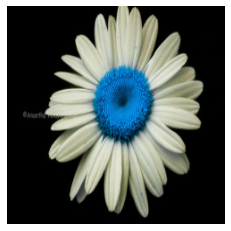

In [40]:
plt.axis('off')
plt.imshow(X_train_scaled[690])

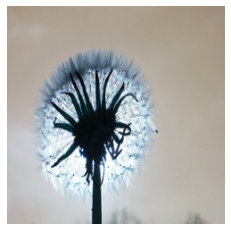

In [41]:
plt.axis('off')
plt.imshow(X_train_scaled[62])

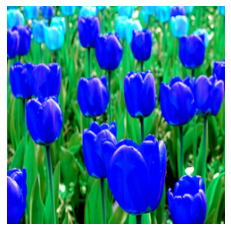

In [42]:
plt.axis('off')
plt.imshow(X_train_scaled[82])

In [43]:
# If we are not performing resizing we have the below error.
x0_resized = cv2.resize(X_train_scaled[690], IMAGE_SHAPE)
x1_resized = cv2.resize(X_train_scaled[62], IMAGE_SHAPE)
x2_resized = cv2.resize(X_train_scaled[82], IMAGE_SHAPE)

![](Screenshot_5.jpg)

In [44]:
# Make the predictions for the 3 images
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 [==============================] - 2s 2s/step


array([986, 678, 866], dtype=int64)

In [51]:
classes[986], classes[678], classes[866]

('daisy', 'nail', 'toyshop')

In [52]:
print(f"The model's predictions are incorrect the last 2 images because it categorize them as a",classes[678], classes[866])

The model's predictions are incorrect the last 2 images because it categorize them as a nail toyshop


**It appears that the model has numerous classes, making it difficult to accurately predict outcomes. One possibility is that the model was trained using an image of a nail and for a tayshop that happens to contain the particular flower in question. Consequently we are experiencing incorrect predictions.**

**Re-Train the Model with our data**

In [53]:
# That happends because this model has been pre-trained on a large dataset for image classification tasks, so we need to re-train it.
# Below we take the same model except for the last layer, meaning all the Dense layers are frozen so that we can add our output.
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# We are reconfiguring our pre-trained model and setting the parameter trainable=False, indicating that we do not want it to be trained, in other words, we want to freeze it.
pretrained_model_without_top_layer = hub.KerasLayer(feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

**Now you can use the pretrained_model_without_top_layer as a layer in your own model**<br>
**This layer will take an image as input and output a feature vector**<br><br>
**So now we can use the pre-trained model and build our own by adding the final layer.**

In [54]:
# First we need to resized the images in the X_train_scaled dataset
resized_images = []
for image_idx in range(len(X_train_scaled)):
    resized_image = cv2.resize(X_train_scaled[image_idx], IMAGE_SHAPE)
    resized_images.append(resized_image)

# Convert the list of resized images to a NumPy array
resized_images = np.stack(resized_images)

In [56]:
num_classes = 5 # Because we have 5 categories of flowers, this will also be the output in our final stream from the ANN.

model = Sequential([
    pretrained_model_without_top_layer,
    layers.Dense(num_classes)
])

model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(resized_images, y_train, epochs=10)

Epoch 1/10
86/86 [==============================] - 82s 801ms/step - loss: 0.8113 - acc: 0.6930
Epoch 2/10
86/86 [==============================] - 62s 719ms/step - loss: 0.4222 - acc: 0.8510
Epoch 3/10
86/86 [==============================] - 66s 763ms/step - loss: 0.3343 - acc: 0.8928
Epoch 4/10
86/86 [==============================] - 61s 712ms/step - loss: 0.2809 - acc: 0.9113
Epoch 5/10
86/86 [==============================] - 66s 771ms/step - loss: 0.2469 - acc: 0.9259
Epoch 6/10
86/86 [==============================] - 65s 754ms/step - loss: 0.2211 - acc: 0.9360
Epoch 7/10
86/86 [==============================] - 62s 719ms/step - loss: 0.1909 - acc: 0.9466
Epoch 8/10
86/86 [==============================] - 62s 719ms/step - loss: 0.1734 - acc: 0.9560
Epoch 9/10
86/86 [==============================] - 62s 716ms/step - loss: 0.1540 - acc: 0.9633
Epoch 10/10
86/86 [==============================] - 62s 718ms/step - loss: 0.1443 - acc: 0.9698


In [60]:
# Resizing the test images to match the expected input shape of the model
resized_test_images = tf.image.resize(X_test_scaled, (224, 224))

# Evaluating the model on the resized test images
model.evaluate(resized_test_images, y_test)

29/29 [==============================] - 23s 727ms/step - loss: 0.3490 - acc: 0.8769


[0.3490244448184967, 0.8769063353538513]

**Test the predictions of the model**

In [61]:
# Generate predictions for all samples in resized_test_images using the re-trained model.
predictions = model.predict(resized_test_images)

29/29 [==============================] - 23s 743ms/step


In [74]:
# keep preds and actual labels in lists
preds = []
actual = []

for index in range(len(resized_test_images)):
    prediction = predictions[index]
    score = tf.nn.softmax(prediction)
    predicted_class_index = np.argmax(score)
    preds.append(predicted_class_index)
    actual.append(y_test[index])

In [75]:
correctPred = 0
wrongPred = 0
for i in preds:

    if preds[i] == actual[i]:
        correctPred += 1
    else:
        wrongPred += 1

print('Predictions who made by the Model we have',correctPred,'correct and', wrongPred, 'wrong')


Predictions who made by the Model we have 918 correct and 0 wrong
